# Converting Swath structured data to Gridded dataset

In [192]:
import xarray as xr
import numpy as np
import h5py
import rasterio
from rasterio.transform import from_origin, from_bounds
from pyresample import kd_tree, geometry, create_area_def, get_area_def, image
from pyresample.ewa import DaskEWAResampler
import pprint
import matplotlib.pyplot as plt
import dask.array as da
from xarray import DataArray
from pyresample.bilinear import NumpyBilinearResampler

In [193]:
filename = '/home/aniket/aniket-backup/anthromet/imerg-data/ku/2A.GPM.Ku.V9-20211125.20230101-S000208-E013440.050238.V07A.hdf5'

In [194]:
data = h5py.File(filename, 'r')

longitude = data['/FS/Longitude'][:]
latitude = data['/FS/Latitude'][:]

binHeavyIcePrecipBottom = data['/FS/CSF/binHeavyIcePrecipBottom'][:]
elevation = data['/FS/PRE/elevation'][:]
PIAhybrid = data['/FS/SRT/PIAhybrid'][:]

resolution = 0.01

longitude.shape

min_lon = longitude.min()
min_lat = latitude.min()
max_lon = longitude.max()
max_lat = latitude.max()

max_lat

66.26229

In [195]:
area_def = create_area_def('world',
                           "+proj=longlat +datum=WGS84 +no_defs +type=crs", # crs
                           area_extent=[-180, -70, 180, 70],
                           resolution=resolution)

swath_def = geometry.SwathDefinition(lons=longitude, lats=latitude)

area_def
swath_def

## Resampling using EWA Algorithm

In [142]:

# resampler = DaskEWAResampler(swath_def, area_def)
# rows_per_scan = 0
# result = resampler.resample(elevation, rows_per_scan=rows_per_scan)

# result

## Resampling using KD_Tree resample_nearest

In [236]:
result = kd_tree.resample_nearest(swath_def, elevation, area_def, radius_of_influence=5000, epsilon=0, fill_value=np.nan)

result

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

## Resampling using Bilinear Resampler

In [ ]:
# resampler = NumpyBilinearResampler(swath_def, area_def, 30e3)
# result = resampler.resample(elevation)

## Resampling using Gauss

In [214]:
# result = kd_tree.resample_gauss(swath_def, elevation, area_def, radius_of_influence=2000000, neighbours=20, sigmas=25000, fill_value=np.nan)
# result

/home/aniket/anaconda3/envs/weather-tools/lib/python3.8/site-packages/pyresample/kd_tree.py:384: UserWarning: Possible more than 20 neighbours within 2000000 m for some data points
  warnings.warn(('Possible more than %s neighbours '


array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

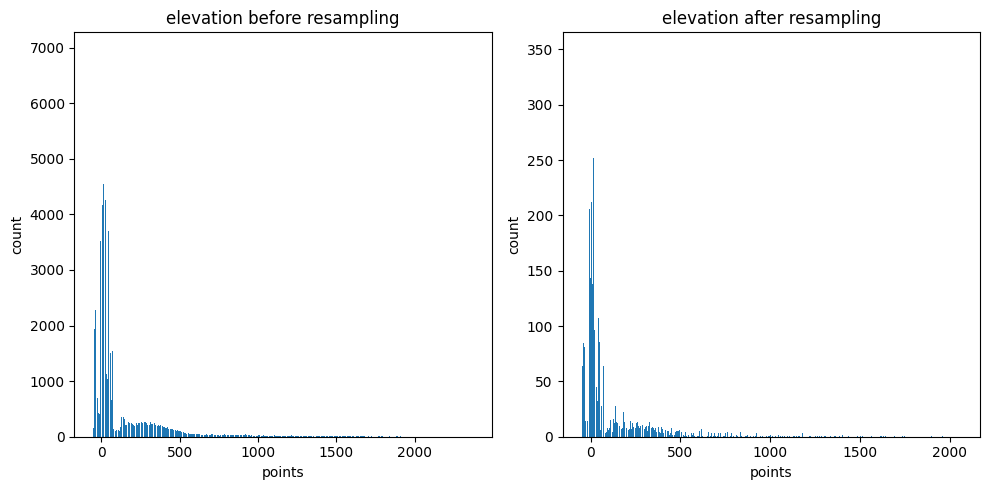

In [237]:
result_u, result_c = zip(np.unique(result, return_counts=True))
orignal_u, orignal_c = zip(np.unique(elevation, return_counts=True))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot the second bar chart on the right subplot
ax1.bar(orignal_u[0], orignal_c[0])
ax1.set_xlabel('points')
ax1.set_ylabel('count')
ax1.set_title('elevation before resampling')

# Plot the first bar chart on the left subplot
ax2.bar(result_u[0], result_c[0])
ax2.set_xlabel('points')
ax2.set_ylabel('count')
ax2.set_title('elevation after resampling')


# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

In [238]:
# Assuming the CRS is EPSG:4326 (WGS84)
crs = rasterio.crs.CRS.from_epsg(4326)
transform = from_origin(-180, 70, resolution, resolution)

In [245]:
type(result.dtype)

numpy.dtype[float32]

In [241]:
output_file = 'kd_4.tif'

with rasterio.open(output_file, 'w', driver='GTiff', height=result.shape[0], width=result.shape[1],
                   count=1, dtype=result.dtype, crs=crs, transform=transform, nodata=np.nan, compress='lzw') as dst:
    dst.write(result, 1)

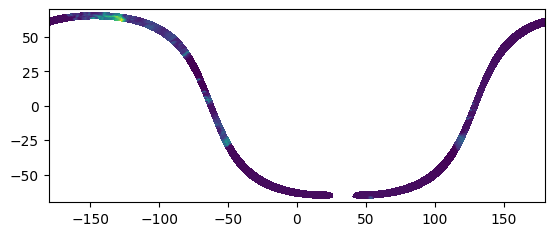

<Axes: >

In [217]:
import rasterio
from rasterio.plot import show
fp = r'/home/aniket/aniket-backup/anthromet/weather-tools-aniket/imerg/gauss_2.tif'
img = rasterio.open(fp)
show(img)

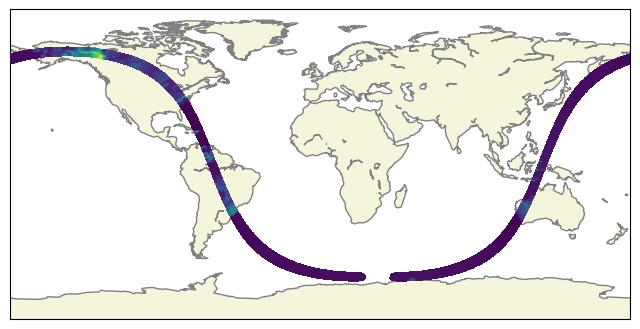

In [242]:
import georaster
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

fig = plt.figure(figsize=(8,8))

# full path to the geotiff file
fpath = r'/home/aniket/aniket-backup/anthromet/weather-tools-aniket/imerg/gauss_2.tif'

# read extent of image without loading
# good for values in degrees lat/long
# geotiff may use other coordinates and projection
my_image = georaster.SingleBandRaster(fpath, load_data=False)

# grab limits of image's extent
minx, maxx, miny, maxy = my_image.extent

# set Basemap with slightly larger extents
# set resolution at intermediate level "i"
m = Basemap( projection='cyl', lon_0=0)

m.drawcoastlines(color="gray")
m.fillcontinents(color='beige')

# load the geotiff image, assign it a variable
image = georaster.SingleBandRaster( fpath, \
                        load_data=(minx, maxx, miny, maxy), \
                        latlon=True)

# plot the image on matplotlib active axes
# set zorder to put the image on top of coastlines and continent areas
# set alpha to let the hidden graphics show through
plt.imshow(image.r, extent=(minx, maxx, miny, maxy), zorder=10)

plt.show()